## Predicting Normal and Hate Speech in Tweets using Gloves vectors

Social media has become an integral part of our daily lives, with Twitter being one of the most popular platforms used to share opinions. Unfourtunately, the increased use of abusive language and hate speech represents a well-known problem on online platforms.

In this Jupyter notebook, I will explore a machine learning approach to classify tweets into normal and hate speech categories using GloVe vectors. GloVe (Global Vectors for Word Representation) is a pre-trained unsupervised method for generating vector representations for words that capture their meanings and relationships in a high-dimensional space.

I will use a dataset of labeled tweets containing normal and hate speech, and train a logistic regression model on the GloVe vectors to predict the class of new tweets. The performance of the model will be evaluated using metrics such as accuracy, precision, recall, and F1-score.

This notebook aims to provide a practical guide to using GloVe vectors for text classification, and to demonstrate the effectiveness of machine learning in detecting hate speech on social media.

## Importing all the required libraries

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import emoji

from gensim.scripts.glove2word2vec import glove2word2vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from scipy.sparse import hstack
from sklearn.model_selection import GridSearchCV
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import matplotlib.pyplot as plt
%matplotlib inline
print("done!")

done!


## Importing the files

In [2]:


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove6b100dtxt/glove.6B.100d.txt
/kaggle/input/normal-hate-and-offensive-speeches/Offensive_Speeches_1.csv
/kaggle/input/normal-hate-and-offensive-speeches/Hate_Speeches_1.csv
/kaggle/input/normal-hate-and-offensive-speeches/Normal_Speeches_1.csv
/kaggle/input/normal-hate-and-offensive-speeches/Normal_Speeches_4.csv
/kaggle/input/normal-hate-and-offensive-speeches/Offensive_Speeches_2.csv
/kaggle/input/normal-hate-and-offensive-speeches/Normal_Speeches_2.csv
/kaggle/input/normal-hate-and-offensive-speeches/Offensive_Speeches_4.csv
/kaggle/input/normal-hate-and-offensive-speeches/Hate_Speeches_4.csv
/kaggle/input/normal-hate-and-offensive-speeches/Normal_Speeches_3.csv
/kaggle/input/normal-hate-and-offensive-speeches/Hate_Speeches_2.csv
/kaggle/input/normal-hate-and-offensive-speeches/Offensive_Speeches_3.csv
/kaggle/input/normal-hate-and-offensive-speeches/Hate_Speeches_3.csv


**Uploading all the required text

First of all, this model will only consider normal and hate speech as a binary variable. To prepare each instance with its label I will proceed at uploading and concatenating the relevant files 

In [3]:
#Get all instances of normal speech
normal_1 = pd.read_csv('/kaggle/input/normal-hate-and-offensive-speeches/Normal_Speeches_1.csv')
normal_2 = pd.read_csv('/kaggle/input/normal-hate-and-offensive-speeches/Normal_Speeches_2.csv')
normal_3 = pd.read_csv('/kaggle/input/normal-hate-and-offensive-speeches/Normal_Speeches_3.csv')
normal_4 = pd.read_csv('/kaggle/input/normal-hate-and-offensive-speeches/Normal_Speeches_4.csv')

df_normal = pd.concat([normal_1,normal_2,normal_3,normal_4], axis=0) # concatenate all normal speech labeled tweets

df_normal.shape


(895, 241)

In [4]:
#get all instances of hate speech 
hate_1 = pd.read_csv('/kaggle/input/normal-hate-and-offensive-speeches/Hate_Speeches_1.csv')
hate_2 = pd.read_csv('/kaggle/input/normal-hate-and-offensive-speeches/Hate_Speeches_2.csv')
hate_3 = pd.read_csv('/kaggle/input/normal-hate-and-offensive-speeches/Hate_Speeches_3.csv')
hate_4 = pd.read_csv('/kaggle/input/normal-hate-and-offensive-speeches/Hate_Speeches_4.csv')

df_hate = pd.concat([hate_1,hate_2,hate_3,hate_4], axis=0)
df_hate.shape

(966, 125)

## Creating the labels and visualising the labels' size

The next step entails creating the labels for each type of speech. Since ML models work on numbers only, I will assign 0 to normal and 1 to hate speech. 

In [5]:
X_hate = df_hate['full_text']
y_hate = [1]*(len(X_hate)) #code hate as 1

In [6]:
X_normal = df_normal ['full_text']
y_normal = [0]*(len(X_normal))

It is important to check label sizes during the preprocessing of a machine learning (ML) model because it can provide useful insights into the balance of the dataset. For this reason, I will check how many istances of the same category are present by visualising a simple bar-plot.

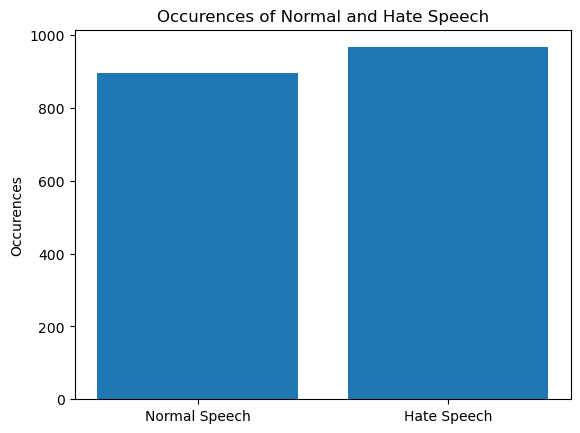

In [7]:
# exploratory analysis, check label sizes

normal_count = (len(X_normal)) 
hate_count = (len(X_hate))

label_counts = [normal_count, hate_count]
label_names =['Normal Speech','Hate Speech']

plt.bar(label_names, label_counts)
plt.title('Occurences of Normal and Hate Speech')
plt.ylabel('Occurences')
plt.show()


The label sizes are very similar. This model is expected to perform well when properly trained

## Creating the labels X and y
After having completed these first steps, it is now time to create X and y. X is the dependent variable and will consist of both normal and hate speech text, whereas the variable y, which the model will attempt to predict, will be constituted by the sum of all labeled instances. 

In [8]:
# create the X label
X_raw = pd.concat([X_normal, X_hate]) 
print(X_raw)

0      Freedom is poetry, taking liberties with words...
1      How is going,Biu?Are you passing peacefully an...
2      u got ball sniffer on your team ofc u would fi...
3      The sensible normal British public have had en...
4      There is a conspiracy to declare all concerned...
                             ...                        
217    I hate people who only text a couple words at ...
218    Yemi makes me hate the words “I got you” If a ...
219    In other words... they hate the truth being to...
220    In Rajasthan's Barmer, Swami Ramdev was very c...
221    I hate decor with words written across it with...
Name: full_text, Length: 1861, dtype: object


In [9]:
# create the y label
y = y_normal + y_hate

## Text preprocessing 

However, the text needs to be further simplified to be turned into numerical vectors. There are a lot of approaches that could be adopted,but, especially in the case of tweets, it is important to strip http tags, emoji and symbols like @ and #, and simplify words that have repeated cahracters. Other steps that are often employed are tokenisation and the removal of stopwords. First, I define a function that performs all these operations and then I apply it to the text

In [10]:
stop_words = set(stopwords.words('english')) #gets the stopword list from the dedicated library and saves them
tk = TweetTokenizer() #defines the object, whose method is called in the function


def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove user mentions
    text = re.sub(r"@\S+", "", text)
    # Remove hashtags
    text = re.sub(r"#\S+", "", text)
    # Remove emojis
    text = emoji.emojize(text, variant='emoji_type')
    # Remove repeated characters (e.g. "soooooo" -> "so")
    text = re.sub(r'(.)\1+', r'\1', text)
    # Lowercase the text
    text = text.lower()
    # Tokenize the text
    words = tk.tokenize(text)
    # Remove stop words
    words = [w for w in words if w not in stop_words]
    # Join the words back into a string
    return ' '.join(words)
    


In [11]:
# Apply the preprocess_text function to the 'text' column
X = X_raw.apply(preprocess_text)

X.head()

0    fredom poetry , taking liberties words , break...
1    going , biu ? pasing peacefuly hapily things l...
2    u got bal snifer team ofc u would find perfect...
3    sensible normal british public enough claptrap...
4    conspiracy declare al concerned citizens acts ...
Name: full_text, dtype: object

## Create the training and testing sets and define the model 
The following step entails dividing the whole dataset into training and test set

In [12]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Importing the GloVe vectors

Now, it is time to build the model. In this case, I have downloaded word2vec and glove, which are pretrained neural network that assigns to each word a numerical vector. This values will be used convert the tweets into integer strings that will be used to classify the documents. This approach was chosen because word embeddings can capture semantic and syntactic relationships between words, and can be used to create distributed representations of text that can be fed into machine learning models. GloVe is a popular pre-trained word embedding model that has been trained on large amounts of text data and can provide high-quality vector representations of words. 

The GloVe file is in a specific format that is not compatible with the gensim library's implementation of KeyedVectors. Converting the file to word2vec format allows the pre-trained embeddings to be loaded and used in a gensim-based machine learning pipeline.

In [13]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

# Load GloVe embeddings
# Convert GloVe file to word2vec format
glove_file = '/kaggle/input/glove6b100dtxt/glove.6B.100d.txt'
word2vec_file = '/kaggle/working/glove.6B.100d.word2vec'
glove2word2vec(glove_file, word2vec_file)

# Load word2vec file as KeyedVectors
from gensim.models import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format(word2vec_file, binary=False)



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  


### Tweets' vectorisation
After having uploaded the related libraries is now time to transform our tokenised tweets into vectors.

The function tweet_to_vec takes a tweet as input, tokenizes it into individual words, looks up the vector representation of each word in pre-trained GloVe embeddings, calculates the mean vector of all the word vectors in the tweet, and returns it as the tweet's vector representation. 

In [14]:
# Convert tweets to GloVe vectors
def tweet_to_vec(tweet):
    tokens = tweet.split()
    vecs = []
    for token in tokens:
        try:
            vec = word_vectors.get_vector(token)
            vecs.append(vec)
        except:
            pass # if the word is not present in the vector list, it is just just skipped
    if len(vecs) == 0:  # this is to handle tweets that have no words that are included in the vector lists 
        return np.zeros((100,)) #it will return a vector list of 0s
    else:
        return np.mean(vecs, axis=0) # if the tweet has a list of vector, it will compute the mean

# apply the function to the train and test set 
X_train_vec = np.stack(X_train.apply(tweet_to_vec))
X_test_vec = np.stack(X_test.apply(tweet_to_vec))

After having defined this function, it is important to convert the vectorised sets from a pandas series object (resulting from apply) thanks a NumPy function that stacks a sequence of arrays along a new axis, resulting in a new array with one more dimension (2 dimensions in this case). Thus, the resulting array X_train_vec has shape (n_samples, 100), where n_samples is the number of tweets in the training dataset, and 100 is the length of the GloVe word vectors used to represent each tweet. 

In [15]:
# apply the function to the train and test set 
X_train_vec = np.stack(X_train.apply(tweet_to_vec))
X_test_vec = np.stack(X_test.apply(tweet_to_vec))

print(X_train_vec, 1)

[[-0.07140809  0.07327548  0.11420885 ... -0.23932625  0.235818
   0.09761649]
 [-0.02881315  0.05371254  0.2027466  ... -0.46185863  0.25893265
   0.13520676]
 [ 0.00742477  0.03418561 -0.08862551 ... -0.32178232  0.24075308
  -0.10321085]
 ...
 [-0.13345328  0.10358742  0.23823614 ... -0.29282469  0.34474221
   0.11850931]
 [-0.20654574 -0.00096095  0.28464901 ... -0.42527166  0.18504262
   0.00240615]
 [ 0.11225546  0.14645582  0.25747254 ... -0.11153037  0.30790383
   0.01508738]] 1


I have chosen to apply logistic regression because it is suited for binary classification. 

### Hyperparameter Tuning 

In order to tune the hyperparameters, I will define a function that evaluates the accuracy of the model for several values of C and display it in a plot, so that I can choose the value that performs the best. C is the regularization parameter which controls the trade-off between fitting the training data well and keeping the model simple. The solver is set to lbfgs, but there was no substantial difference between the score of different solvers. 

In [16]:

def plot_regularization_performance(X_train, y_train, X_test, y_test, C_values):
    train_scores = []
    test_scores = []
    for C in C_values:
        model = LogisticRegression(C=C, solver = 'lbfgs', max_iter=1000)
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        train_scores.append(train_acc)
        test_scores.append(test_acc)

    plt.plot(C_values, train_scores, label='Training Accuracy')
    plt.plot(C_values, test_scores, label='Test Accuracy')
    plt.xlabel('Regularization Parameter (C)')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

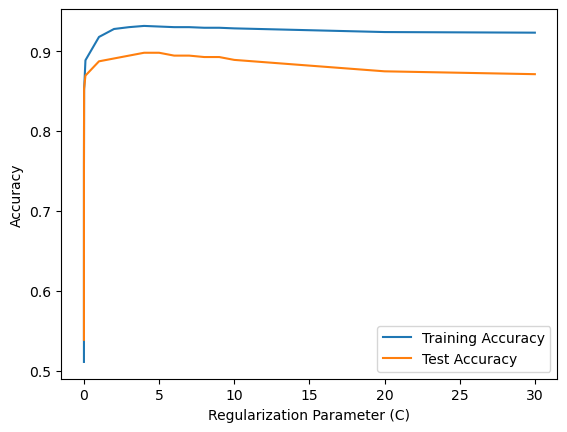

In [17]:
C_values = [0.0001,0.001, 0.01, 0.1, 1, 2, 3,4,5,6,7,8,9,10,20,30]
plot_regularization_performance(X_train_vec, y_train, X_test_vec, y_test, C_values)

## Applying Logistic Regression
5 seems to perform well, for this reason I will use this value for C when applying Log Regression to the datasets

In [18]:
# Define the logistic regression model
lr_model = LogisticRegression(C=5, solver='lbfgs', max_iter=1000)

# Fit the model on the training data
lr_model.fit(X_train_vec, y_train)

# Predict on the testing data
y_pred = lr_model.predict(X_test_vec)

# Print the accuracy score and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8980322003577818
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       258
           1       0.91      0.90      0.91       301

    accuracy                           0.90       559
   macro avg       0.90      0.90      0.90       559
weighted avg       0.90      0.90      0.90       559



With an accuracy score of 0.89, the model performs well. Now I will plot the confusion matrix to visualise the ratio of false negatives and positives.

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


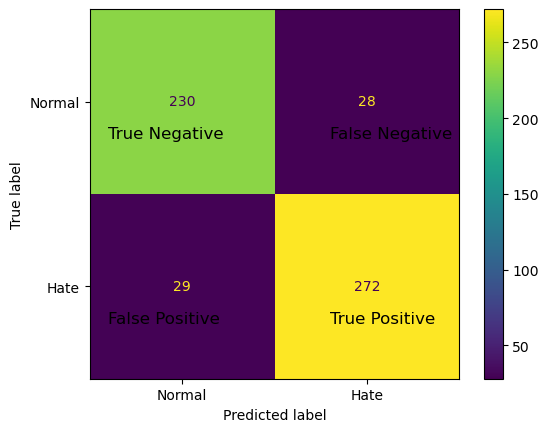

In [19]:
labs = ['Normal', 'Hate']

plot_confusion_matrix(lr_model, X_test_vec, y_test, display_labels = labs)
plt.text(-0.4, 0.2, "True Negative", fontsize=12)
plt.text(-0.4, 1.2, "False Positive", fontsize=12)
plt.text(0.8, 0.2, "False Negative", fontsize=12)
plt.text(0.8, 1.2, "True Positive", fontsize=12)



plt.show()

The plot shows how the number of false positives and negatives is low, thus showing that the model works well.

## Conclusion

In this notebook, I explored the use of GloVe vectors and logistic regression for the classification of tweets into normal and hate speech categories. Using the pre-trained GloVe vectors and logistic regression, I was able to build a model that achieved an accuracy of 90% on the test data.

The performance of the model was evaluated using various metrics, including precision, recall, and F1-score. The model demonstrated a high level of precision and recall for the hate speech class, indicating that it is effective at detecting this type of speech.

Overall, this notebook provides a practical guide to using GloVe vectors and logistic regression for text classification and demonstrates their effectiveness in detecting hate speech in tweets. 